# Preliminary Regen Solver

### Import libraries

In [105]:
# general
import os
import numpy as np
import pandas as pd

# thermo
import cantera as ct

# numerical methods
import scipy.optimize

# visualization / other
import matplotlib.pyplot as plt

### Manage Directories

In [106]:
plotfolder = "solverplots/"
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

### Main parameter defintions
Define the main parameters below:

In [107]:
P0 = 2.758e+6 # First Chamber (Stagnation) Pressure Guess [Pa]
Ti = 300      # First Chamber Inlet Temperature Guess [K]
OF = 10.2     # OF ratio used

### Using Cantera to Find Exhaust Gas Properties in Chamber

In [108]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight # average molecular weight of gas [kg / kmol]
mu0 = gas.viscosity # dynamic viscosity [Pa s]

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/kmol]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 26.203541670258993 [kg/kmol]


### Defining Exhaust Gas and Coolant Transport Property Functions
Below we define various functions used to retrieve transport properties for the exhaust gases and coolant (<em>using known temperature $T$ and pressure $P$ values, as well as Mach number $M$ along the chamber</em>).

In [109]:
# define exhaust gas transport properties - using Cantera
def cp_exhaust(T, p):
    gas.TP = T, p
    return gas.cp # [J/kg K]

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity # [Pa s]

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

def rho_exhaust(T, p):
    gas.TP = T, p
    return gas.density # [kg/m^3]

def free_vel_exhaust(T, p, M):
    gas.TP = T, p
    return gas.sound_speed * M # [m/s]



### Retrieve Chamber Geometry
Engine Geometry is defined as a function of axial position:
- r(x) - radius of chamber
- th(x) - thickness of chamber wall

The r(x) is retrieved from the engine sizing file (<em>run this file if you haven't yet to create $enginegeometry.csv$ file</em>)<br>

Additional Geometry Paramters such as throat area $A_t$ and throat axial position $x_t$ are also retrieved.

In [110]:
# read geometry csv file to pandas
df = pd.read_csv("enginefiles/enginegeometry.csv", sep=",")

# extract geometry 
x = df["x [m]"].to_list()
r = df["r [m]"].to_list()

# read parameter csv file to pandas
df = pd.read_csv("enginefiles/engineparameters.csv", sep=",")

# extract parameters
A_t = df["A_t [m^2]"].to_list()[0]
A_e = df["A_e [m^2]"].to_list()[0]
A_c = df["A_c [m^2]"].to_list()[0]
x_c = df["x_c [m]"].to_list()[0]
x_t = df["x_t [m]"].to_list()[0]


print("x:", x, "\nr:", r, "\nA_t:", A_t, "\nx_t:", x_t, "\nA_e:", A_e)

x: [0.0, 0.1498965449294315, 0.2276826954333716, 0.3119321703278378] 
r: [0.0635, 0.0635, 0.0185901450673254, 0.0411647238280437] 
A_t: 0.0010857139806982 
x_t: 0.2276829224364471 
A_e: 0.0053235370982499


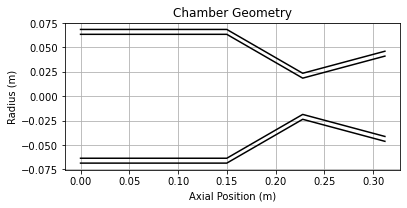

In [111]:
# define function for thickness of chamber wall th(x)

# Note: Currently Using Constant Thickness
const_thickness = 0.005 # [m]
def variable_thickness(x):
    return const_thickness
th = np.array([variable_thickness(_x) for _x in x ]) # thickness of chamber wall [m] 
    

# plot chamber geometry
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.savefig(plotfolder + "enginegeometry.png", dpi=300)


### Define Injector Geometry

In [112]:
""" PLACEHOLDER CODE """
Ao = 0 # total cross sectional area of orifice [m^2]

#### (Placeholder: Coolant Channel Geometry, Nitrous and Ethane Input state)

### Discretize Engine into N Slices
To run the solver we must slice our engine into discrete section - reffered to as nodes from here on out. 

Each node has the following properties associated with it:
- $x$ - axial position of node
- $r$ - a radius of the chamber at that node
- $A$ - the cross sectional area of the chamber at that node
- $M$ - Mach number at that node of exhaust gas
- $T$ - temperature of exhaust gas at node
- $P$ - pressure of exhaust gas at node
- $OD$ - chamber wall outer diameter (ignoring cooling jacket)
- $w$ - channel width at node
- $T_{hw}$ - hot gas side wall temperature (set by user)
- $q$ - steady state heat flow rate at node

In [113]:
# Define N
N = 100 # number of nodes

In [114]:
# Define Node Object
class Node:

    # constructor and setters
    def _init_(self):
        self.x = 0
        self.r = 0
        self.A = 0
        self.M = 0
        self.T = 0
        self.P = 0
        self.OD = 0
        self.w = 0
        self.T_hw = 0
        self.q = 0
    
    def set_x(self, x):
        self.x = x
    
    def set_r(self, r):
        self.r = r

        # implicilty calculate area from r
        self.A = np.pi * r**2
    
    def set_M(self, M):
        self.M = M

    def set_T(self, T):
        self.T = T

    def set_P(self, P):
        self.P = P

    def set_OD(self, OD):
        self.OD = OD

    def set_w(self, w):
        self.w = w

    def set_T_hw(self, T_hw):
        self.T_hw = T_hw

    def set_q(self, q):
        self.q = q

    # set exhaust gas properties
    def set_exhaust(self, gas):
        self.cp = gas.mean_molecular_weight
        self.mu = gas.T
        self.Pr = gas.Pr
        self.OD = gas.density

    # special methods
    def printNode(self): # for testing
        return "Node at x = {} m with r = {} m and A = {} m^2".format(self.x, self.r, self.A)
    
    def getFullReport(self):
        return "Node at x = {} m with r = {} m and A = {} m^2\nM = {}\nT = {} K\nP = {} Pa\nOD = {} m\nw = {} m\nT_hw = {} K".format(self.x, self.r, self.A, self.M, self.T, self.P, self.OD, self.w, self.T_hw)


To freely discretize the geometry of the chamber we must find some functional form of expressing the geometry. Since our chamber is linear - we will just fit various straight line segments between the given geometry points.

In [115]:
# finding x positons for various pairs of points
points12x = x[:2] # points 1 and 2
points23x = x[1:3] # points 2 and 3
points34x = x[2:4] # points 3 and 4

# finding r positons for various pairs of points
points12r = r[:2] # points 1 and 2
points23r = r[1:3] # points 2 and 3
points34r = r[2:4] # points 3 and 4

# finding slopes and intercepts for various pairs of points
slope12, intercept12 = np.polyfit(points12x, points12r, 1) # points 1 and 2
slope23, intercept23 = np.polyfit(points23x, points23r, 1) # points 2 and 3
slope34, intercept34 = np.polyfit(points34x, points34r, 1) # points 3 and 4

# print all linear equations obtained
print("r = {}x + {}".format(slope12, intercept12))
print("r = {}x + {}".format(slope23, intercept23))
print("r = {}x + {}".format(slope34, intercept34))


r = -1.3887365930630215e-16x + 0.06349999999999999
r = -0.5773502691896256x + 0.15004281056560206
r = 0.26794919243112186x + -0.04241724930458759


Find node axial positons, radii, and wall outer diameters.

In [116]:
x_n = np.linspace(x[0], x[-1], N) # x positions of nodes
r_n = np.zeros_like(x_n) # r positions of nodes
OD_n = np.zeros_like(x_n) # outer diameter of chamber wall of nodes

for i, el in enumerate(x_n):
    # find r_n
    if el <= x[1]:
        node_r_n = slope12 * el + intercept12
    elif el <= x[2]:
        node_r_n = slope23 * el + intercept23
    else:
        node_r_n = slope34 * el + intercept34

    # set r_n
    r_n[i] = node_r_n

    # set wallOD
    OD_n[i] = 2 * (node_r_n + variable_thickness(el))

# print results
'''
print("x_n:", x_n)
print("r_n:", r_n)
'''


'\nprint("x_n:", x_n)\nprint("r_n:", r_n)\n'

### Creating Node List
To work with each node we can store them in an array (of size $N$).

In [117]:
# create size N array of Nodes
nodes = np.empty(N, dtype=Node)

# set x and r values of each node
for i, el in enumerate(nodes):
    el = Node()
    el.set_x(x_n[i])
    el.set_r(r_n[i])
    el.set_OD(OD_n[i])
    nodes[i] = el


### Solving Exhaust Gas State at Each Slice
To solve the exhaust gas state at each slice we can use the isentropic flow equations for T and P, i.e. $T = T_0(1+\frac{k-1}{2}M^2)^{-1}$ and $p=p_0(1+\frac{k-1}{2}M^2)^{\frac{-k}{k-1}}$.<br>

But as is apparent, to do so we must first find the Mach number $M$ at each axial position of the chamber.

One potential method to do this is to use the formula for nozzle area ratio in terms of Mach number. If we look at the nozzle area ratio with the throat area $r_A = \frac{A}{A_t}$ using the fact that at the throat $M = 1$ we get the expression $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$. This relates the area $A$ at any axial section to the Mach number $M$.

However, solving such an equation for Mach number $M$ given area $A$ directly is difficult, therefore we would need to use a numerical solution method (<em>such as the $root\_ scalar()$ method offered by scipy</em>).


### Finding Mach Number $M$ at Each Slice
If we try to solve for $M$ from the relation $r_A(M)$, we will get 2 solutions given a certain $A$ (<em>this is illustrated graphically in Appenidx A lower below</em>). These 2 solutions correspond accordingly to subsonic flow and supersonic flow (<em>i.e. if we just give an area $A$ and try to find the $M$ from the equation $r_A(M)$ we would get 2 Mach number $M$ values - one $M_{conv}$ if the area $A$ would be in the convergent section and one $M_{div}$ if the area would be in the divergent section </em>).

Therefore we have to separate the subsonic flow and supersonic flow cases.

In [118]:
# express r_A as a function of k and M
def A_At(M, k):
    return 1/M * ( (2 + (k-1) * M**2) / (k + 1) )**( (k+1) / (2 * (k-1) ) )

# define function to find M when flow is subsonic
def get_M_subsonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1e-5, 1], x0 = 0.5).root # the bracket is the range of values to search for the root, x0 is the initial guess

def get_M_supersonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1, 500], x0 = 1).root # the bracket is the range of values to search for the root, x0 is the initial guess

# print Mach number at exit area (supersonic) as a test
print("Mach number at exit area:", get_M_supersonic(A_e, A_t, kc))
print("Mach number at throat:", get_M_subsonic(A_t, A_t, kc))
print("Mach number at chamber entrance:", get_M_subsonic(A_c, A_t, kc))

Mach number at exit area: 2.8436539472162603
Mach number at throat: 1.0
Mach number at chamber entrance: 0.05057441153715261


In [119]:
# find Mach number at each node
for node in nodes:
    if node.x < x_c:
        node.set_M(0) # if node is in chamber, M = 0
    elif node.x < x_t:
        node.set_M(get_M_subsonic(node.A, A_t, kc)) # if node is in convergent section, M is subsonic
    else:
        node.set_M(get_M_supersonic(node.A, A_t, kc)) # if node is in divergent section, M is supersonic

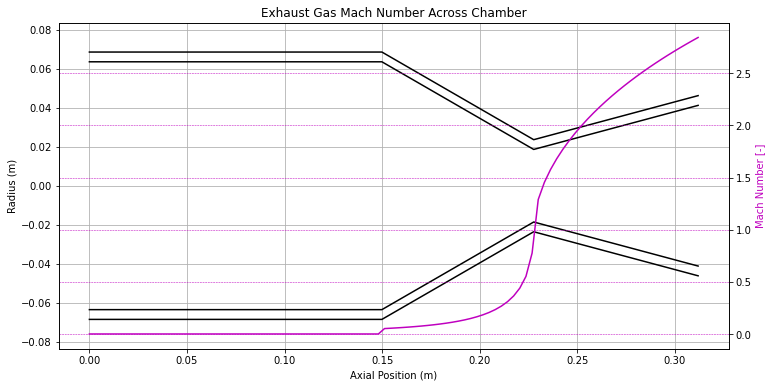

In [120]:
# plot Mach number at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Mach Number Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "m", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.M for node in nodes], color = "m")
axs2.set_ylabel("Mach Number [-]", color = "m")
plt.savefig(plotfolder + "machvsenginegeometry.png", dpi=300)
plt.show()

### Finding Temperature $T$ and Pressure $P$ of Gas at Each Node
To find $T$ and $P$ we use the Mach number at each node and the isentropic equations listed before.

In [121]:
# defining isentropic flow equations for static T and P of exhaust gas given M, kc, T0, and P0
def isen_T(M, kc, T0):
    return T0*(1 + ((kc - 1)/2) * M**2)**(-1)

def isen_P(M, kc, P0):
    return P0*(1 + ((kc - 1)/2) * M**2)**((-kc)/(kc - 1))

In [122]:
# populate nodes array with T and P values - find temperature and pressue at each node
for node in nodes:
    if node.M == 0:  # set T and P to stagnation values if node is in chamber
        node.set_T(T0)
        node.set_P(P0)
    else:
        node.set_T(isen_T(node.M, kc, T0))
        node.set_P(isen_P(node.M, kc, P0))

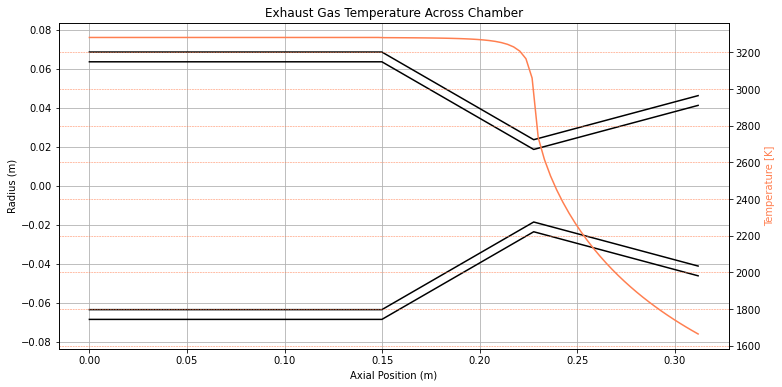

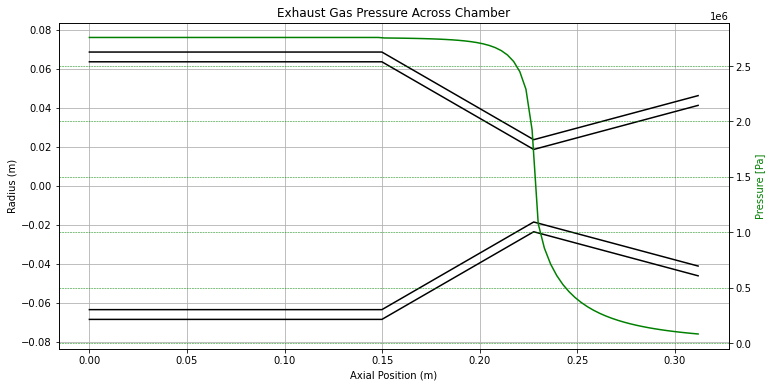

In [123]:
# plot Temperature at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Temperature Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "coral", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.T for node in nodes], color = "coral")
axs2.set_ylabel("Temperature [K]", color = "coral")
plt.savefig(plotfolder + "tempvsenginegeometry.png", dpi=300)
plt.show()

# plot Pressure at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Pressure Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "g", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.P for node in nodes], color = "g")
axs2.set_ylabel("Pressure [Pa]", color = "g")
plt.savefig(plotfolder + "presvsenginegeometry.png", dpi=300)
plt.show()

### Defining Target Chamber Wall Temperature
In this section we define the target chamber wall temperature $T_{t}$ at each node. The values defined here will be the assumed (<em>target</em>) values for the hot wall temperature i.e. $T_{hw} = T_t$. From this, we will calculate the steady state heat flux at every node and therefore the temperatures at the various layers of the chamber at each node.<br>

For Inconel - we wish to keep the hot wall temperature below $\approx 1373$ K at each node.

In [124]:
# define function T(x) to define target temperature of hot wall at each node
T_constant = 1373 # [K]
def T_hw(x):
    return T_constant # for now, just define a constant temperature

# populate nodes with target hot wall temperatures
for node in nodes:
    node.set_T_hw(T_hw(node.x))

### Defining Cooling Jacket Geometry Constraints
In the following section our goal is to determine the cooling jacket geometry, specifically the width of the coolant channels at each axial position (node). We constrain the geometry by setting the following variables:
- N_channels - number of cooling channels in the jacket
- t_rib - rib thickness

Based on these variables, the outer diameter of the chamber wall is used to create a 2D envelope of the engine outer wall surface. Along this envelope the cooling channels are evenly distributed with a constant rib thickness between them. This means that the width of the channels decreases as the outer diameter of the chamber wall decreases.<br>

Using this cooling jacket geometry, we later solve for the cooling channel height.

In [125]:
# define cooling jacket geometry parameters
N_channels = 15 # number of cooling channels
t_rib = 0.0075 # thickness of ribs [m]

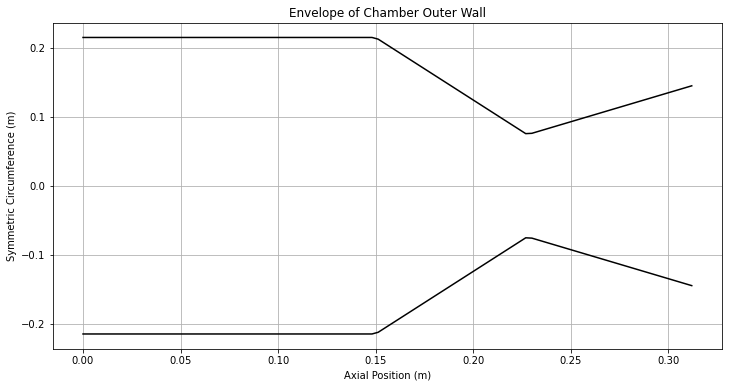

In [126]:
# plot the chamber outer wall envelope
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x_n, (OD_n * np.pi) / 2, color = "k")
axs.plot(x_n, -(OD_n * np.pi) / 2, color = "k")
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Symmetric Circumference (m)")
axs.set_title("Envelope of Chamber Outer Wall")
plt.show()

<b>At every node calculate:</b>  
- $C$ - circumference
- $L_{rt}$ - total length of circumference occupied by ribs
- $w$ - channel width

Channel width $w$ at every node is calculated as the circumference of the chamber ($C = (OD) * \pi$) minus the total rib length $L_{rt}$ divided by the amount of channels.  

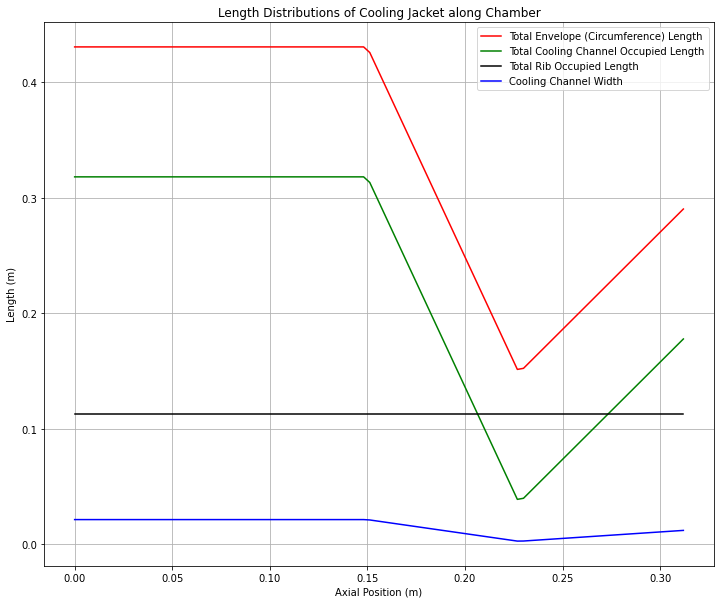

Range of cooling channel width: 2.580435436536349 to 21.193212902786772 [mm]


In [127]:
# calculate length of ribs at all envelope sections - for N_channels cooling channels there will be N_channels ribs (when counting going around the circumference)
C = np.pi * OD_n # circumference of chamber outer wall at each node
L_rt = [(N_channels) * t_rib for i in range(N)] # total circumference length occupied by ribs at each node
w = (C - L_rt) / N_channels # width of each cooling channel

if min(w) < 0:
    print("ERROR: Cooling channel width is negative at one or more nodes. Please check cooling jacket geometry parameters.")
    
# plot results: length occupied by rib, length occupied by walls and total envelope length (circumference) at each node
fig, axs = plt.subplots(figsize = (12, 10))
fig.set_facecolor('white')
axs.plot(x_n, C, color = "r", label = "Total Envelope (Circumference) Length")
axs.plot(x_n, C - L_rt, color = "g", label = "Total Cooling Channel Occupied Length")
axs.plot(x_n, L_rt, color = "k", label = "Total Rib Occupied Length")
axs.plot(x_n, w, color = "b", label = "Cooling Channel Width")
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Length (m)")
axs.set_title("Length Distributions of Cooling Jacket along Chamber")
axs.legend()
plt.show()

# print results
print("Range of cooling channel width:", min(w) * 1000.0, "to", max(w) * 1000.0, "[mm]")

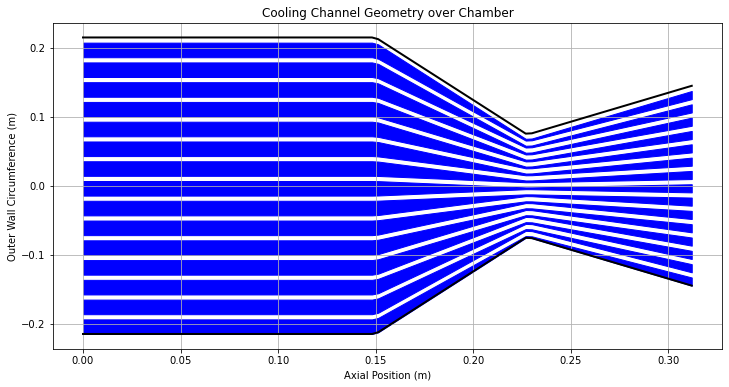

<Figure size 432x288 with 0 Axes>

In [128]:
# visualize channel geometry by plotting channel walls on top of chamber outer wall envelope
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.grid()
# plot chamber envelope
axs.plot(x_n, (OD_n * np.pi) / 2, color = "k", linewidth = 2)
axs.plot(x_n, -(OD_n * np.pi) / 2, color = "k", linewidth = 2)

#axs.fill_between(x_n, (OD_n * np.pi) / 2, -(OD_n * np.pi) / 2, color = "gray") # color in ribs
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Outer Wall Circumference (m)")
axs.set_title("Cooling Channel Geometry over Chamber")
for i in range(N_channels):
    axs.fill_between(x_n, - (OD_n * np.pi) / 2 + i * (t_rib + w), - (OD_n * np.pi) / 2 + i * (t_rib + w) + w, color = "b") # at the x-th position with respective outer diameter OD and channel width w plot the i-th channel
plt.show()
plt.savefig(plotfolder + "coolingchannelenvelope.png", dpi=300)

The main purpose of the cooling jacket geometry definition was to obtain the coolant channel width at every node - which we assign to each node below.

In [129]:
# assign each node the width of the cooling channels at that node
for i, el in enumerate(nodes):
    el.set_w(w[i])

## Iterating Over all Nodes to find Heat Flow, Layer Temperatures and Coolant State 

Because the coolant will flow from nozzle to injector we must first reverse the order of the nodes in our node list.

In [130]:
# reverse order of nodes array
nodes = nodes[::-1]

### Solving for Heat Flow at each Node
To solve for heat flow at each node, we first find the convective heat transfer coefficient $h_g$ for the gas film layer from the Bartz equation $h_g = \frac{0.026}{D^{0.2}}(\frac{c_p \mu^{0.2}}{Pr^{0.6}})(\rho v)^{0.8} (\frac{\rho_{am}}{\rho'})(\frac{\mu_{am}}{\mu_0})^{0.2}$ using the transport properties defined before.

In [131]:
def h_gas_bartz(D, cp, mu, Pr, rho, v, rho_am, mu_am, mu0):
    """
    Bartz equation, using Equation (8-23) from page 312 of RPE 7th edition (Reference [1]). 'am' refers to the gas being at the 'arithmetic mean' of the wall and freestream temperatures.

    Args:
        D (float): Gas flow diameter (m)
        cp_inf (float): Specific heat capacity at constant pressure for the gas, in the freestream
        mu_inf (float): Absolute viscosity in the freestream
        Pr_inf (float): Prandtl number in the freestream
        rho_inf (float): Density of the gas in the freestream
        v_inf (float): Velocity of the gas in in the freestream
        rho_am (float): Density of the gas, at T = (T_wall + T_freestream)/2, P - exhaust static pressure
        mu_am (float): Absolute viscosity of the gas, at T = (T_wall + T_freestream)/2, P - exhaust static pressure
        mu0 (float): Absolute viscosity of the gas under stagnation conditions.
        
    Returns:
        float: Convective heat transfer coefficient (W/m2/K), h, for the exhaust gas side (where q = h(T - T_inf)).
    """

    return (0.026/D**0.2) * (cp*mu**0.2)/(Pr**0.6) * (rho * v)**0.8 * (rho_am/rho) * (mu_am/mu0)**0.2

# for node 0
D = 2 * nodes[0].r # diameter of gas flow at node 0
cp = cp_exhaust(nodes[0].T, nodes[0].P) # specific heat capacity at constant pressure for the gas, in the freestream
mu = mu_exhaust(nodes[0].T, nodes[0].P) # absolute viscosity in the freestream
Pr = Pr_exhaust(nodes[0].T, nodes[0].P) # Prandtl number in the freestream
rho = rho_exhaust(nodes[0].T, nodes[0].P) # density of the gas in the freestream
v = free_vel_exhaust(nodes[0].T, nodes[0].P, nodes[0].M) # velocity of the gas in in the freestream
rho_am = rho_exhaust((nodes[0].T + nodes[0].T_hw) / 2.0, nodes[0].P) # density of the gas, at T = (T_wall + T_freestream)/2
mu_am = mu_exhaust((nodes[0].T + nodes[0].T_hw) / 2.0, nodes[0].P) # absolute viscosity of the gas, at T = (T_wall + T_freestream)/2

# for each node in list calculate h_gas and heat flow rate
for node in nodes:
    D = 2 * node.r # diameter of gas flow at node
    cp = cp_exhaust(node.T, node.P) # specific heat capacity at constant pressure for the gas, in the freestream
    mu = mu_exhaust(node.T, node.P) # absolute viscosity in the freestream
    Pr = Pr_exhaust(node.T, node.P) # Prandtl number in the freestream
    rho = rho_exhaust(node.T, node.P) # density of the gas in the freestream
    v = free_vel_exhaust(node.T, node.P, node.M) # velocity of the gas in in the freestream
    rho_am = rho_exhaust((node.T + node.T_hw) / 2.0, node.P) # density of the gas, at T = (T_wall + T_freestream)/2
    mu_am = mu_exhaust((node.T + node.T_hw) / 2.0, node.P) # absolute viscosity of the gas, at T = (T_wall + T_freestream)/2

    # calculate film coefficeint h_gas and heat flow rate q
    h_gas = h_gas_bartz(D, cp, mu, Pr, rho, v, rho_am, mu_am, mu0) # [W/m^2/K]
    q = h_gas * (node.T - node.T_hw) # [W/m^2]

    # set node values
    node.set_q(q)


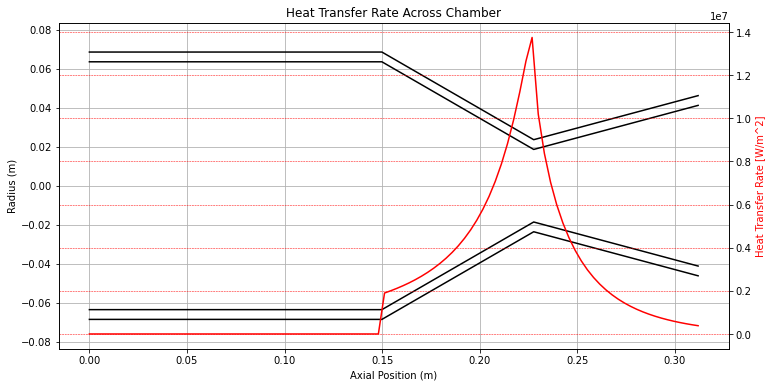

In [132]:
# plot results
# first need to reverse node list back to original order
nodes = nodes[::-1]

fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Heat Transfer Rate Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "r", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.q for node in nodes], color = "r")
axs2.set_ylabel("Heat Transfer Rate [W/m^2]", color = "r")
plt.savefig(plotfolder + "heatvsenginegeometry.png", dpi=300)
plt.show()

# rereverse node list
nodes = nodes[::-1]

### Export Relevant Data to CSV files

In [133]:
# use pandas t export Mach number, temperature, and pressure data to csv
nodedf = pd.DataFrame({"x [m]": x_n, "r [m]": r_n, "M [-]": [node.M for node in nodes], "T [K]": [node.T for node in nodes], "P [Pa]": [node.P for node in nodes]})

# export to csv
nodedf.to_csv("enginefiles/nodedata.csv")

#### Appendix A
Illustration of the nature of equation $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$.

Plotting $r_A(M)$ for different $M$ values. (<em>Horizontal line of expansion ratio $A_e/A_t$ shown</em>). From the following grap it is clear to see that for a given $A$ (<em>or more precisely $\frac{A}{A_t}$</em>) there are 2 solutions to $M$.

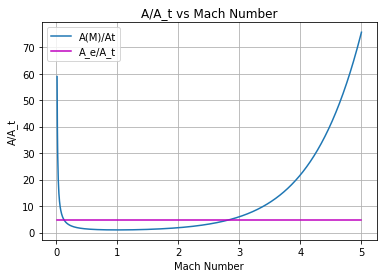

In [134]:
# plot A_At vs M varying M from 1e-2 to 5
# also plat horizontal line of A_e/A_t
fig, axs = plt.subplots()
fig.set_facecolor('white')
M = np.linspace(1e-2, 5, 1000)
axs.plot(M, A_At(M, kc), label = "A(M)/At")
axs.plot(M, A_e/A_t * np.ones(len(M)), color = "m", label = "A_e/A_t")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A/A_t")
axs.set_title("A/A_t vs Mach Number")
plt.legend()
plt.show()

The way we find particular solutions is to find the points (the Mach numbers $M$ on the horizontal axis) where the difference between our area ratio in question $\frac{A}{A_t}$ and that given by the equation $r_A(M)$ is zero (<em>i.e. find the $M$ values that solve $r_A(M) = \frac{A}{A_t}$</em>).

The plots of the <em>error</em> / <em>difference</em> function $\frac{A_e}{A_t} - r_A(M)$ for a particular area (<em> exit area $A_e$</em>) for which we numerically find a root is given below in both the subsonic and supersonic regions.

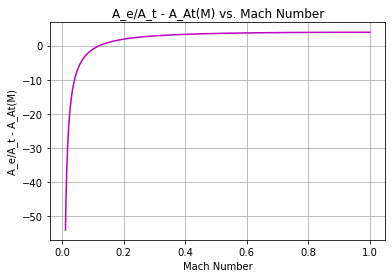

In [135]:
# plot A_e/A_t - A_At() varying M - subsonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1e-2, 1, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()


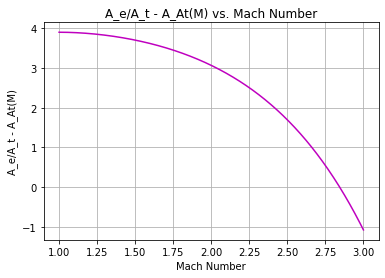

In [136]:
# plot A_e/A_t - A_At() varying M - supersonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1, 3, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()